# Problem 2

# a

UK Bonds Descriptive Statistics:
                9M          10M          11M          1Yr          2Yr  \
count  1114.000000  1114.000000  1114.000000  1114.000000  1114.000000   
mean      0.606243     0.615272     0.622387     0.627968     0.652469   
std       0.739794     0.752527     0.763275     0.772297     0.811767   
min      -0.152838    -0.152099    -0.151283    -0.150365    -0.141956   
25%       0.033821     0.036256     0.037021     0.038475     0.070717   
50%       0.576708     0.576935     0.575290     0.572878     0.514220   
75%       0.742246     0.740818     0.742547     0.742764     0.756484   
max       4.058905     4.138379     4.205084     4.261181     4.532579   

               3Yr          5Yr          7Yr         10Yr         13Yr  \
count  1114.000000  1114.000000  1114.000000  1114.000000  1114.000000   
mean      0.675018     0.754557     0.865536     1.062691     1.250681   
std       0.811861     0.798015     0.783513     0.769411     0.761103   
min 

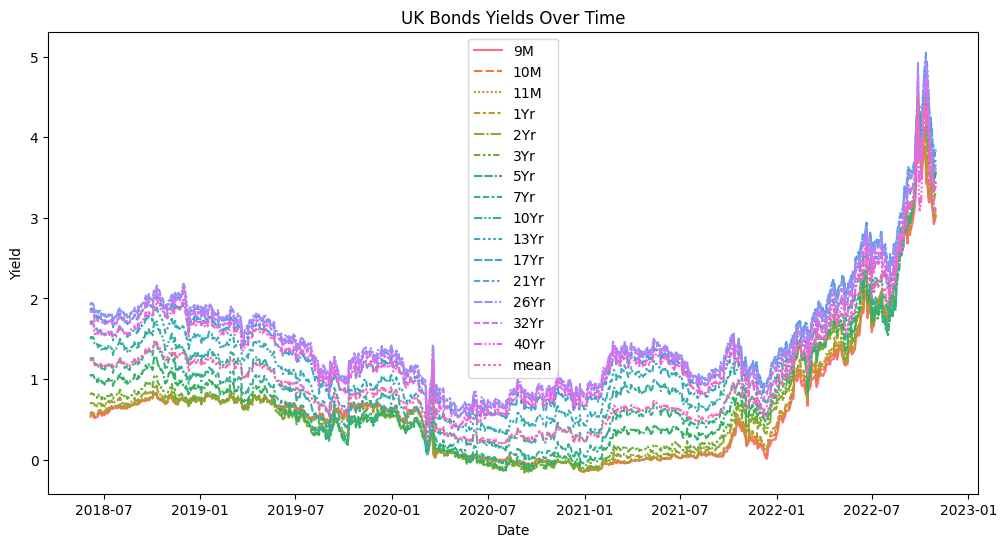

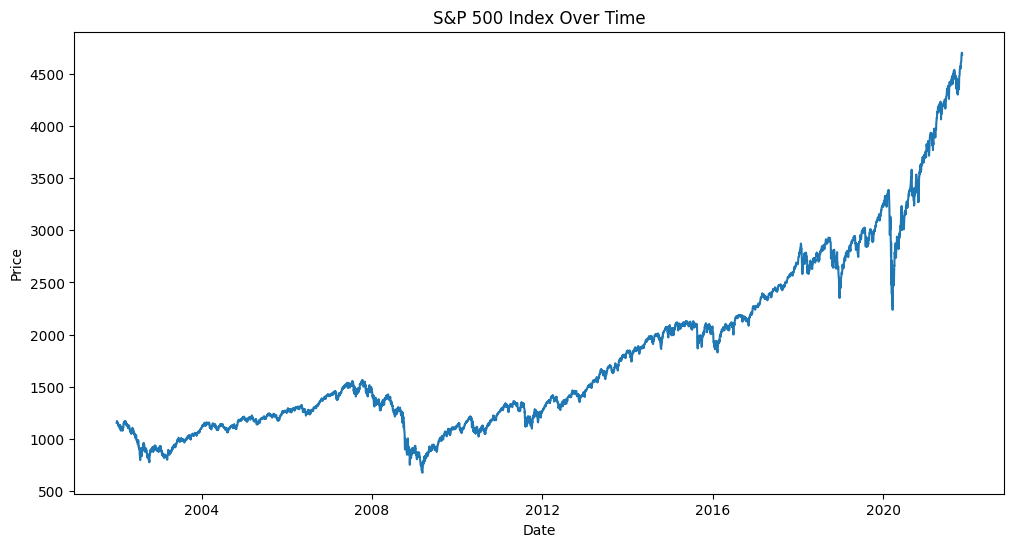

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

bonds = pd.read_parquet('UK_bonds.parquet')
bonds['mean'] = bonds.mean(axis=1)
sp500 = pd.read_csv('S_P 500 Historical Data.csv')

# descriptive statistics
print("UK Bonds Descriptive Statistics:")
print(bonds.describe())

#sp500
sp500['Price'] = pd.to_numeric(sp500['Price'].str.replace(',', ''))
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500 = sp500.sort_values('Date')
print(sp500)
# Generate descriptive statistics for 'Price'
print("S&P 500 'Price' Descriptive Statistics:")
print(sp500['Price'].describe())

# Plot bond time-series graphs
plt.figure(figsize=(12, 6))
sns.lineplot(data=bonds)
plt.title('UK Bonds Yields Over Time')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.show()

# 'Date' as the index
sp500.set_index('Date', inplace=True)

# Plot sp500 time-series graph
plt.figure(figsize=(12, 6))
sns.lineplot(data=sp500['Price'])
plt.title('S&P 500 Index Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# b

In [6]:
from statsmodels.tsa.stattools import adfuller

def calculate_adf_statistics(s, p):
    # ADF test for HA: stationary
    result_stationary = adfuller(s, maxlag=p)
    adf_t_stat_stationary = result_stationary[0]
    adf_delta_stat_stationary = len(s) * result_stationary[1]
    critical_values_stationary = result_stationary[4]

    # ADF test for HA: trend-stationary
    result_trend_stationary = adfuller(s, maxlag=p, regression='ct')
    adf_t_stat_trend_stationary = result_trend_stationary[0]
    adf_delta_stat_trend_stationary = len(s) * result_trend_stationary[1]
    critical_values_trend_stationary = result_trend_stationary[4]

    return (adf_t_stat_stationary, adf_t_stat_trend_stationary, 
            adf_delta_stat_stationary, adf_delta_stat_trend_stationary, 
            critical_values_stationary, critical_values_trend_stationary)
#sp500
adf_stats_sp500 = calculate_adf_statistics(sp500['Price'], p=1)
print("ADF Statistics for S&P 500:")
print("ADF t statistic (stationary):", adf_stats_sp500[0])
print("ADF t statistic (trend-stationary):", adf_stats_sp500[1])
print("ADF δ statistic (stationary):", adf_stats_sp500[2])
print("ADF δ statistic (trend-stationary):", adf_stats_sp500[3])

# bonds_mean
bonds_mean_series = bonds.mean(axis=1)
adf_stats_bonds_mean = calculate_adf_statistics(bonds_mean_series, p=1)

print("ADF Statistics for Mean of Bonds:")
print("ADF t statistic (stationary):", adf_stats_bonds_mean[0])
print("ADF t statistic (trend-stationary):", adf_stats_bonds_mean[1])
print("ADF δ statistic (stationary):", adf_stats_bonds_mean[2])
print("ADF δ statistic (trend-stationary):", adf_stats_bonds_mean[3])


ADF Statistics for S&P 500:
ADF t statistic (stationary): 2.7940719079293372
ADF t statistic (trend-stationary): 0.36871262979113933
ADF δ statistic (stationary): 5000.0
ADF δ statistic (trend-stationary): 4982.602683195922
ADF Statistics for Mean of Bonds:
ADF t statistic (stationary): 1.002721271551447
ADF t statistic (trend-stationary): 0.22624313463674714
ADF δ statistic (stationary): 1107.64416022752
ADF δ statistic (trend-stationary): 1109.4560202696653


# c

In [8]:
def simulate_and_test(s, N, T, p):
    # Calculate the difference of s
    delta_s = s.diff().dropna()

    # Initialize a DataFrame to store the results
    results = pd.DataFrame(0, index=['1%', '5%', '10%'], columns=['ADF t (stationary)', 'ADF t (trend-stationary)', 'ADF δ (stationary)', 'ADF δ (trend-stationary)'])

    # Simulate N random walks and run the ADF test
    for i in range(N):
        # Bootstrap from delta_s to generate a random walk
        random_walk = delta_s.sample(T, replace=True).cumsum()

        # Run the ADF test
        adf_t_stat_stationary, adf_t_stat_trend_stationary, adf_delta_stat_stationary, adf_delta_stat_trend_stationary, critical_values_stationary, critical_values_trend_stationary = calculate_adf_statistics(random_walk, p)

        # Compare the ADF statistics with the critical values
        for level in ['1%', '5%', '10%']:
            results.loc[level, 'ADF t (stationary)'] += adf_t_stat_stationary < critical_values_stationary[level]
            results.loc[level, 'ADF t (trend-stationary)'] += adf_t_stat_trend_stationary < critical_values_trend_stationary[level]
            results.loc[level, 'ADF δ (stationary)'] += adf_delta_stat_stationary < critical_values_stationary[level]
            results.loc[level, 'ADF δ (trend-stationary)'] += adf_delta_stat_trend_stationary < critical_values_trend_stationary[level]

    # Calculate the average of the results
    results = results.div(N)

    return results

#bond
results_bonds = simulate_and_test(bonds_mean_series, N=5000, T=252, p=1)
print("Results for Bonds:")
print(results_bonds)

#sp500
results_sp500 = simulate_and_test(sp500['Price'], N=5000, T=252, p=1)
print("Results for S&P 500:")
print(results_sp500)

Results for Bonds:
     ADF t (stationary)  ADF t (trend-stationary)  ADF δ (stationary)  \
1%                0.010                    0.0128                 0.0   
5%                0.045                    0.0552                 0.0   
10%               0.089                    0.1066                 0.0   

     ADF δ (trend-stationary)  
1%                        0.0  
5%                        0.0  
10%                       0.0  
Results for S&P 500:
     ADF t (stationary)  ADF t (trend-stationary)  ADF δ (stationary)  \
1%               0.0108                    0.0118                 0.0   
5%               0.0490                    0.0524                 0.0   
10%              0.0940                    0.1060                 0.0   

     ADF δ (trend-stationary)  
1%                        0.0  
5%                        0.0  
10%                       0.0  
